## Pension Simulation Model (no risk sharing)

In [ ]:
import numpy as np
import pandas as pd
from scipy.ndimage.interpolation import shift
from scipy.stats import invgauss, norm
import random


def pension_optimization2(
                         r = 0.065 ,     # Portfolio average return
                         sd = 0.08,      #Portfolio standard deviation
                         life_yr = 82,      # Life expectancy
                         salary = 40000,     # Starting salary
                         salary_increase = 0.025,   #Salary increase/yr
                         target = 0.7,         # Target pension as % of final salary
                         accrual = 0.02,         # Pension accrual rate/yr
                         work_c = 0.19,           # Worker contribution rate
                         employ_c = 0.19):      # Employer contribution rate



  #Calculate Salary array
  years = np.array(range(36))
  S = np.full((1, 36), salary)[0]
  S_all = S * ((1 + salary_increase)** years)
  S_all = S_all
  S_shift = shift(S_all, 1)    # shift salary (for lag 1 calculation)



  Total_c = work_c + employ_c
  Pension_contribution = S_shift * Total_c


  #Target_pension_benefit = np.ones(36)          
  Target_pension_benefit = accrual * years * S_all[35]
  Target_benefit = Target_pension_benefit[35]



  Actual_notional_account = np.array([Pension_contribution[0:2]])[0]
  Target_notional_account = np.array([Pension_contribution[0:2]])[0]


  pension_sum = 0


  for i in range(2, 58):

    if i < 36:
      Target_notional_account[0] = Target_notional_account[1]
      Target_notional_account[1] = ((1+r) * Target_notional_account[0]) + Pension_contribution[i]

      Fund_return = norm.ppf(random.random(), loc=r, scale=sd)
      Actual_notional_account[0] = Actual_notional_account[1]
      return_amount =  Actual_notional_account[0] * Fund_return
      Actual_notional_account[1] = return_amount + Pension_contribution[i] + Actual_notional_account[0]


    elif i == 36:
      Target_notional_account[0] = Target_notional_account[1]
      Target_notional_account[1] =  ((1+r) * Target_notional_account[0]) - Target_benefit  

      pension_payment = (Actual_notional_account[0] / Target_notional_account[0]) * Target_benefit
      Actual_notional_account[0] = Actual_notional_account[1]
      Fund_return = norm.ppf(random.random(), loc=r, scale=sd)
      Actual_notional_account[1] = Fund_return + Actual_notional_account[1] - pension_payment
      pension_sum += pension_payment


    else:
      Target_notional_account[0] = Target_notional_account[1]
      Target_notional_account[1] =  ((1+r) * Target_notional_account[0]) - Target_benefit
      
      pension_payment = (Actual_notional_account[0] / Target_notional_account[0]) * Target_benefit
      Fund_return = norm.ppf(random.random(), loc=r, scale=sd)
      Actual_notional_account[0] = Actual_notional_account[1]
      return_amount =  Actual_notional_account[0] * Fund_return
      Actual_notional_account[1] = Fund_return + Actual_notional_account[1] - pension_payment
      pension_sum += pension_payment

  return pension_sum






def monte_carlo2(r_mean, r_sigma, times, wage, wage_increase, pension_target, penson_accrual, w_contribution, e_contribution):

    result2 = pd.DataFrame(columns = ['Total_payment'])

    for i in range(times):

      x = pension_optimization2( r = r_mean ,     # Portfolio average return
                         sd = r_sigma,      #Portfolio standard deviation
                         life_yr = 82,      # Life expectancy
                         salary = wage,     # Starting salary
                         salary_increase = wage_increase,   #Salary increase/yr
                         target = pension_target,         # Target pension as % of final salary
                         accrual = penson_accrual,         # Pension accrual rate/yr
                         work_c =  w_contribution,           # Worker contribution rate
                         employ_c = e_contribution)      # Employer contribution rate
 
    
      result2.loc[i] = x

    
    return result2


## Run the model

In [ ]:
import time
start = time.time()


r_mean = 0.1
r_sigma = 0.1    
life_yr = 82,      
wage = 100   
wage_increase = 0.025   
pension_target = 0.7        
penson_accrual = 0.02         
w_contribution = 0.0           
e_contribution = 0.0
times = 100

result2 = monte_carlo2(r_mean, r_sigma, times, wage, wage_increase, pension_target, penson_accrual, w_contribution, e_contribution)


end = time.time()
runtime = end-start
print("Iterates %s times, takes %s sec" %(times, runtime))
               

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in double_scalars


Iterates 100 times, takes 1.4598958492279053 sec


In [ ]:
result2

,Total_payment
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
95,NaN
96,NaN
97,NaN
98,NaN


In [ ]:
################################################################# 

## Pension Model (Risk sharing)


#### Risk Sharing Logic:
- the total return each year = pre-adjusted notional return - possible contribution to reserve + possible withdrawal from reserve + possible excess reserve (above 15%)



Possible contribution happens when:
1. pre-adjusted notional return is positive
2. surplus situation
3.  = min( transfer rate% of pre-adjusted notional return, max withdrawal to get back to surplus, max withdrawal to avoid depleting the reserve)

Possible withdraw happens when:
1. deficit situation
2. = min(transfer rate% of pre-adjusted notional return, max withdrawal to get back to surplus, max withdrawal to avoid depleting the reserve)

Excess reserve happens when:
1.  As pensions are paid out,  the reserve could go above the 15% threshold 
2. considers the hypothetical excess reserve (above 15% of assets)

In [35]:
import numpy as np
import pandas as pd
from scipy.ndimage.interpolation import shift
from scipy.stats import invgauss, norm
import random


def pension_optimization3( 
                          r = 0.15 ,     # Portfolio average return
                         sd = 0.10,      #Portfolio standard deviation
                         life_yr = 82,      # Life expectancy
                         salary = 25405,     # Starting salary
                         salary_increase = 0.021,   #Salary increase/yr
                         target = 0.7,         # Target pension as % of final salary
                         accrual = 0.02,         # Pension accrual rate/yr
                         work_c = 0.19,           # Worker contribution rate
                         employ_c = 0.19,        # Employer contribution rate
                         transfer_rate = 0.1,       # transfer rate to reserve
                         max_reserve= 0.15,        # max reserve to assets rate
                         other_assets_initial= 75000, 
                        initial_reserve_to_asset= 0.1 ):   


  
  #Calculate Salary array
  years = np.array(range(36))
  S = np.full((1, 36), salary)[0]
  S_all = S * ((1 + salary_increase)** years)
  S_all = S_all
  S_shift = shift(S_all, 1)    # shift salary (for lag 1 calculation)



  Total_c = work_c + employ_c
  Pension_contribution = S_shift * Total_c
  


  #Target_pension_benefit = np.ones(36)          
  Target_pension_benefit = accrual * years * S_all[35]
  Target_benefit = Target_pension_benefit[35]



  pre_Adjusted_notional_account = np.array([Pension_contribution[0:2]])[0]
  Actual_notional_account = np.array([Pension_contribution[0:2]])[0]
  Target_notional_account = np.array([Pension_contribution[0:2]])[0]

  Contribution = np.zeros(2)
  Contribution_sum = 0
  Withdraw = np.zeros(2)
  Withdraw_sum = 0
  
  Excess_reserve = np.zeros(2)
  other_assets = np.ones(2)

  Fund_first = 1 + norm.ppf(random.random(), loc=r, scale=sd)   # fund returm execute first
  other_assets[0] = other_assets_initial
  other_assets[1] = other_assets_initial * (Fund_first)   

  Reserve = np.zeros(2)
  Reserve[0] =  ((other_assets[0] + (other_assets[0] * initial_reserve_to_asset)) * initial_reserve_to_asset) + (other_assets[0] * (initial_reserve_to_asset**3) )
  Reserve[1] = (Reserve[0] * (1 + Fund_first )) + Contribution[1] - Withdraw[1]


  distributions_others = np.zeros(2)
  pension_sum = 0
  Excess_reserve_sum = 0
  distributions_others_sum = 0

  pre_Adjusted_return = np.zeros(2)
  


  for i in range(2, 58):

    if i < 36:                                                                      ######################################################
      Target_notional_account[0] = Target_notional_account[1]

      Target_notional_account[1] = ((1+r) * Target_notional_account[0]) + Pension_contribution[i]

      Fund_return = norm.ppf(random.random(), loc=r, scale=sd)

      Actual_notional_account[0] = Actual_notional_account[1]

      pre_Adjusted_return[0] =  pre_Adjusted_return[1]
      pre_Adjusted_return[1] =  Actual_notional_account[0] * Fund_return


      


      

      Contribution[0] = Contribution[1]
      Withdraw[0] = Withdraw[1]
      Excess_reserve[0] = Excess_reserve[1]

      distributions_others[0] = distributions_others[1]
      
      other_assets[0] =  other_assets[1]


  

      
      

      pre_Adjusted_notional_account[0] =  pre_Adjusted_notional_account[1]
      pre_Adjusted_notional_account[1] = Actual_notional_account[0] + Pension_contribution[i] + pre_Adjusted_return[1]
      

     






# Contribution Logic
      if pre_Adjusted_notional_account[1]/Target_notional_account[1] > 0 and Fund_return > 0:
         C1 =  transfer_rate *  pre_Adjusted_return[1]
         C2 =  pre_Adjusted_notional_account[1] - Target_notional_account[1]
         C3 =  (max_reserve * ((Reserve[0] * (1 + Fund_return)) +  (pre_Adjusted_notional_account[1]) + (other_assets[1] * (1 + Fund_return)) - (Reserve[0] * (1 + Fund_return))))

         Contribution_value = min([C1, C2, C3])
         if Contribution_value <=0:
            Contribution[1] = 0
         else:
            Contribution[1] = Contribution_value
      else:
         Contribution[1] = 0

      Contribution_sum += Contribution[1]
      

        
         
# withdraw logic 
      if (pre_Adjusted_notional_account[1]/Target_notional_account[1]) < 1 :
         W1 = transfer_rate * abs(pre_Adjusted_return[1])        
         W2 = Reserve[0] * (1 + Fund_return)       
         W3 = (Target_notional_account[1] - pre_Adjusted_notional_account[1])
         
         
         
        
         Withdraw_value = min([W1, W2, W3])

         if Withdraw_value > 0:
            Withdraw[1] = Withdraw_value
         else:
            Withdraw_value = 0
      else:
         Withdraw_value = 0
         
         Withdraw[1] = Withdraw_value
      
      Withdraw_sum += Withdraw[1]



# Excess reserve logic
      s = (Reserve[0] * (1 + Fund_return))
      a = pre_Adjusted_notional_account[1] + (other_assets[0]*(1 + Fund_return)) + (Reserve[0] * (1 + Fund_return))

      if s/a > max_reserve:
         x = s / ((a - max_reserve) * a)
         if x > 0:
            Excess_reserve[1] = x
      
      else:
         Excess_reserve[1] = 0

      Excess_reserve_sum += Excess_reserve[1]
      

      Actual_notional_account[1] =  pre_Adjusted_notional_account[1] - Contribution[1] + Withdraw[1] + Excess_reserve[1] 
      Reserve[0] = Reserve[1]
      Reserve[1] = (Reserve[0] * (1 + Fund_return)) + Contribution[1] - Withdraw[1]

      distributions_others[1] = Excess_reserve[1] * (other_assets[0] * (1 + (Fund_return))) / (pre_Adjusted_notional_account[1] - Contribution[1] + Withdraw[1] + (other_assets[0] * (1 + (Fund_return))))
      other_assets[1] = (other_assets[0] * (1 + Fund_return)) + distributions_others[1] 
      distributions_others_sum += distributions_others[1]





    elif i == 36:                                                                   #################################################################
      Target_notional_account[0] = Target_notional_account[1]
      Target_notional_account[1] =  ((1+r) * Target_notional_account[0]) - Target_benefit  

      pension_payment = (Actual_notional_account[0] / Target_notional_account[0]) * Target_benefit
      
      pension_sum += pension_payment
      



      Actual_notional_account[0] = Actual_notional_account[1]
      Fund_return = norm.ppf(random.random(), loc=r, scale=sd)

      pre_Adjusted_return[0] =  pre_Adjusted_return[1]
      pre_Adjusted_return[1] =  Actual_notional_account[0] * Fund_return

    
      Contribution[0] = Contribution[1]
      Withdraw[0] = Withdraw[1]
      Reserve[0] = Reserve[1]
      Excess_reserve[0] = Excess_reserve[1]

         

      pre_Adjusted_notional_account[0] =  pre_Adjusted_notional_account[1]
      pre_Adjusted_notional_account[1] = Actual_notional_account[0] + pension_payment + pre_Adjusted_return[1]



# Contribution Logic
      if pre_Adjusted_notional_account[1]/Target_notional_account[1] > 0 and Fund_return > 0:
         C1 =  transfer_rate *  pre_Adjusted_return[1]
         C2 =  pre_Adjusted_notional_account[1] - Target_notional_account[1]
         C3 =  (max_reserve * ((Reserve[0] * (1 + Fund_return)) +  (pre_Adjusted_notional_account[1]) + (other_assets[1] * (1 + Fund_return)) - (Reserve[0] * (1 + Fund_return))))

         Contribution_value = min([C1, C2, C3])
         if Contribution_value <=0:
            Contribution[1] = 0
         else:
            Contribution[1] = Contribution_value
      else:
         Contribution[1] = 0

      Contribution_sum += Contribution[1]


# withdraw logic 
      if (pre_Adjusted_notional_account[1]/Target_notional_account[1]) < 1 :
         W1 = transfer_rate * abs(pre_Adjusted_return[1])
         W2 = Reserve[0] * (1 + Fund_return)
         W3 = Target_notional_account[1] - pre_Adjusted_notional_account[1]
         

         Withdraw_value = min([W1, W2, W3])

         if Withdraw_value > 0:
            Withdraw[1] = Withdraw_value
         else:
            Withdraw_value = 0
      else:
         Withdraw_value = 0
         
         Withdraw[1] = Withdraw_value
      
      Withdraw_sum += Withdraw[1]

# Excess reserve logic
      s = (Reserve[0] * (1 + Fund_return))
      a = pre_Adjusted_notional_account[1] + (other_assets[0]*(1 + Fund_return)) + (Reserve[0] * (1 + Fund_return))

      if s/a > max_reserve:
         x = s / ((a - max_reserve) * a)
         if x > 0:
            Excess_reserve[1] = x
      
      else:
         Excess_reserve[1] = 0

      Excess_reserve_sum += Excess_reserve[1]
      
      

      Actual_notional_account[1] =  pre_Adjusted_notional_account[1] - Contribution[1] + Withdraw[1] + Excess_reserve[1] 
      Reserve[0] = Reserve[1]
      Reserve[1] = (Reserve[0] * (1 + Fund_return)) + Contribution[1] - Withdraw[1]

      distributions_others[1] = Excess_reserve[1] * (other_assets[0] * (1 + (Fund_return))) / (pre_Adjusted_notional_account[1] - Contribution[1] + Withdraw[1] + (other_assets[0] * (1 + (Fund_return))))
      other_assets[1] = (other_assets[0] * (1 + Fund_return)) + distributions_others[1] 

      distributions_others_sum += distributions_others[1]

      

    else:                                                                           ##################################
      
      Fund_return = norm.ppf(random.random(), loc=r, scale=sd)
      
      Target_notional_account[0] = Target_notional_account[1]
      Target_notional_account[1] =  ((1+r) * Target_notional_account[0]) - Target_benefit  

      pension_payment = (Actual_notional_account[0] / Target_notional_account[0]) * Target_benefit
      
      pension_sum += pension_payment
      



      Actual_notional_account[0] = Actual_notional_account[1]
      Fund_return = norm.ppf(random.random(), loc=r, scale=sd)

      

      pre_Adjusted_notional_account[0] =  pre_Adjusted_notional_account[1]
      pre_Adjusted_notional_account[1] = Actual_notional_account[0] + pre_Adjusted_return[1] - pension_payment

    
      Contribution[0] = Contribution[1]
      Withdraw[0] = Withdraw[1]
      Reserve[0] = Reserve[1]
      Excess_reserve[0] = Excess_reserve[1]


      pre_Adjusted_notional_account[0] =  pre_Adjusted_notional_account[1]
      pre_Adjusted_notional_account[1] = Actual_notional_account[0] + pension_payment + pre_Adjusted_return[1]

      



# Contribution Logic
      if pre_Adjusted_notional_account[1]/Target_notional_account[1] > 0 and Fund_return > 0:
         C1 =  transfer_rate *  pre_Adjusted_return[1]
         C2 =  pre_Adjusted_notional_account[1] - Target_notional_account[1]
         C3 =  (max_reserve * ((Reserve[0] * (1 + Fund_return)) +  (pre_Adjusted_notional_account[1]) + (other_assets[1] * (1 + Fund_return)) - (Reserve[0] * (1 + Fund_return))))

         Contribution_value = min([C1, C2, C3])
         if Contribution_value <=0:
            Contribution[1] = 0
         else:
            Contribution[1] = Contribution_value
      else:
         Contribution[1] = 0

      Contribution_sum += Contribution[1]


# withdraw logic 
      if (pre_Adjusted_notional_account[1]/Target_notional_account[1]) < 1 :
         W1 = transfer_rate * abs(pre_Adjusted_return[1])
         W2 = Reserve[0] * (1 + Fund_return)
         W3 = Target_notional_account[1] - pre_Adjusted_notional_account[1]
         

         Withdraw_value = min([W1, W2, W3])

         if Withdraw_value > 0:
            Withdraw[1] = Withdraw_value
         else:
            Withdraw_value = 0
      else:
         Withdraw_value = 0
         
         Withdraw[1] = Withdraw_value
      
      Withdraw_sum += Withdraw[1]

# Excess reserve logic
      s = (Reserve[0] * (1 + Fund_return))
      a = pre_Adjusted_notional_account[1] + (other_assets[0]*(1 + Fund_return)) + (Reserve[0] * (1 + Fund_return))

      if s/a > max_reserve:
         x = s / ((a - max_reserve) * a)
         if x > 0:
            Excess_reserve[1] = x
      
      else:
         Excess_reserve[1] = 0

      Excess_reserve_sum += Excess_reserve[1]
 

      Actual_notional_account[1] =  pre_Adjusted_notional_account[1] - Contribution[1] + Withdraw[1] + Excess_reserve[1] 
      Reserve[0] = Reserve[1]
      Reserve[1] = (Reserve[0] * (1 + Fund_return)) + Contribution[1] - Withdraw[1]

      distributions_others[1] = Excess_reserve[1] * (other_assets[0] * (1 + (Fund_return))) / (pre_Adjusted_notional_account[1] - Contribution[1] + Withdraw[1] + (other_assets[0] * (1 + (Fund_return))))
      other_assets[1] = (other_assets[0] * (1 + Fund_return)) + distributions_others[1] 
      distributions_others_sum += distributions_others[1]


    if i == 58:
      pension_sum += (pre_Adjusted_notional_account[1] + Actual_notional_account[0])   #########################
      

  return pension_sum, Contribution_sum, Withdraw_sum, Excess_reserve_sum, distributions_others_sum






def monte_carlo3(r_mean = 0.065, 
                 r_sigma = 0.08, 
                 times = 100 , 
                 wage = 40000, 
                 wage_increase =  0.025 , 
                 pension_target = 0.7, 
                 penson_accrual = 0.02, 
                 w_contribution = 0.19, 
                 e_contribution = 0.19, 
                 transfer = 0.1, 
                 max_store = 0.15, 
                 other_assets =75000 , 
                 initial_reserve = 0.1 ):

    result3 = pd.DataFrame(columns = ['Total_payment', 'Total_Contribution', 'Total_Withdraw','Total_Excess_Reserve', 'Total_Excess_reserve_to_Others'])

    for i in range(times):

      x = pension_optimization3(
                          r = r_mean ,      # Portfolio average return
                         sd = r_sigma,       #Portfolio standard deviation
                         life_yr = 82,       # Life expectancy
                         salary = wage,      # Starting salary
                         salary_increase = wage_increase,    #Salary increase/yr
                         target = pension_target,          # Target pension as % of final salary
                         accrual = penson_accrual,          # Pension accrual rate/yr
                         work_c = w_contribution,            # Worker contribution rate
                         employ_c = e_contribution,         # Employer contribution rate
                         transfer_rate = transfer,        # transfer rate to reserve
                         max_reserve= max_store,           # max reserve to assets rate
                         other_assets_initial= other_assets , 
                        initial_reserve_to_asset= initial_reserve )
    
      result3.loc[i] = x

    
    return result3


In [39]:
import time
start = time.time()


## default parameters

r_mean = 0.65
r_sigma = 0.8
Times = 1000
wage = 40000
wage_increase =  0.025
pension_target = 0.7
penson_accrual = 0.02
w_contribution = 0.0573
e_contribution = 0.0573  # 4-8
transfer = 0.1   # 6-14
max_store = 0.15 
other_assets = 75000  
initial_reserve = 0.1

#for x in range(4, 9, 1):
#  w_contribution = x/100
#  e_contribution = x/100
#  for 


test = monte_carlo3(
                    r_mean, 
                    r_sigma, 
                    Times, 
                    wage, 
                    wage_increase, 
                    pension_target, 
                    penson_accrual, 
                    w_contribution, 
                    e_contribution, 
                    transfer, 
                    max_store, 
                    other_assets, 
                    initial_reserve )


end = time.time()
runtime = end-start
print("Iterates %s times, takes %s sec" %(Times, runtime))

Iterates 1000 times, takes 18.344911575317383 sec


## Quantile

In [43]:
np.mean(test['Total_payment'])
  

74777.59745399046

In [41]:
Q10 = test['Total_payment'].quantile(q=0.10)
Q25 = test['Total_payment'].quantile(q=0.25)
Q50 = test['Total_payment'].quantile(q=0.50)
Q75 = test['Total_payment'].quantile(q=0.75)
Q90 = test['Total_payment'].quantile(q=0.90)

print(Q10)
print(Q25)
print(Q50)
print(Q75)
print(Q90)

-3872.299850210361
-17.171420516833088
464.8988372584639
15984.063574249816
155987.57034300722


## Quantile Visualization

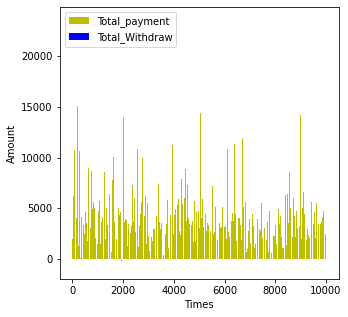

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (5, 5))
payment = plt.bar(test.index, test['Total_payment'], color = 'y')
plt.xlabel('Times')
plt.ylabel('Amount')
Total_Withdraw = plt.bar(test.index, test['Total_Withdraw'], color = 'b')
plt.legend(handles=[payment,Total_Withdraw],labels=['Total_payment','Total_Withdraw'],loc='best')
